# Piano Music Sentiment Classification
Jason Shu, Joseph Poirier, Paul Scott<br>
CIS 522 Final Project<br>
University of Pennsylvania<br>

# Setup

Download required libraries

In [ ]:
%%capture
!sudo apt install -y fluidsynth
!pip install pretty_midi
!pip install --upgrade pyfluidsynth
!pip install spotipy
!pip install tensorflow-addons

Imports

In [ ]:
import collections
import pandas as pd
import numpy as np
import pretty_midi
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from itertools import product
import matplotlib.pyplot as plt
import spotipy
from IPython import display
from spotipy.oauth2 import SpotifyClientCredentials
from google.colab import drive
from heapq import nlargest
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Download Dataset

Download maestro dataset

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip

--2022-04-28 17:56:26--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.251.18.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M  41.5MB/s    in 1.3s    

2022-04-28 17:56:28 (41.5 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]



Unzip dataset

In [ ]:
%%capture
!unzip maestro-v3.0.0-midi.zip -d .

## Helper Functions

Get notes from midi files

In [ ]:
# function modified from: https://www.tensorflow.org/tutorials/audio/music_generation
def midi_to_notes(midi_file, num_notes=100) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # return empty dataframe if midi file has less than the requested number of notes
  if len(instrument.notes) < num_notes:
    return pd.DataFrame(columns=['midi_filename', 'order', 'pitch', 'step', 'duration'])

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  # create note data
  for i, note in enumerate(sorted_notes):
    start = note.start
    end = note.end
    notes['midi_filename'].append(midi_file)
    notes['order'].append(i)
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

    if i + 1 == num_notes:
      break

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

Helper functions for adding harmony

In [ ]:
# add harmony as an attribute
def add_harmony(notes, N, threshold):
  held_notes = {}
  pitch_class_dists = []
  i = 0
  for i in range(len(notes)):
    note = notes.iloc[i]
    # initialize a dict for pitch classes (C, E, B, Bb, etc.)
    pitch_class_dist = {get_note_name(x):0 for x in range(12)}
    # for all notes held over from before, check if ended or count overlap with current note
    held_notes_to_delete = []
    for held_note, held_end_time in held_notes.items():
      if held_end_time <= note.start:
        held_notes_to_delete.append(held_note)
      else:
        overlap = calculate_overlap(note.start, note.end, note.start, held_end_time)
        if overlap > threshold:
          pitch_class_dist[get_note_name(held_note)] += calculate_overlap(note.start, note.end, note.start, held_end_time)

    # update held note dictionary
    for x in held_notes_to_delete:
      del held_notes[x]
    held_notes[note.pitch] = note.end
    # consider all forthcoming overlapping notes
    j = i + 1
    while j < len(notes) and notes.iloc[j].start < note.end:
      overlap = calculate_overlap(note.start, note.end, notes.iloc[j].start, notes.iloc[j].end)
      if overlap > threshold:
        pitch_class_dist[get_note_name(notes.iloc[j].pitch)] += calculate_overlap(note.start, note.end, notes.iloc[j].start, notes.iloc[j].end)
      j += 1
    # store the pitch class distribution
    pitch_class_dists.append(pitch_class_dist)
  
  top_pitch_classes = [return_top_n_classes(dist, N) for dist in pitch_class_dists]
  mlb = MultiLabelBinarizer(sparse_output = True)
  mlb.fit([[get_note_name(x) for x in range(12)]])
  new_df = notes.join(pd.DataFrame.sparse.from_spmatrix(
                mlb.transform(top_pitch_classes),
                index=notes.index,
                columns=mlb.classes_))
  new_df['pitch'] /= 128
  
  return new_df.drop(['start', 'end'], axis = 1)

def get_pitch_class(pitch):
  return pitch % 12

def get_note_name(pitch):
  pitch_classes = {0 : 'C', 1 : 'C#/Db', 2 : 'D', 3 : 'D#/Eb', 4 : 'E', 5 : 'F', \
                  6 : 'F#/Gb', 7 : 'G', 8 : 'G#/Ab', 9 : 'A', 10 : 'A#/Bb', 11 : 'B'}
  return pitch_classes[get_pitch_class(pitch)]

def calculate_overlap(a_start_time, a_end_time, b_start_time, b_end_time):
  return max(min(a_end_time, b_end_time) - max(a_start_time, b_start_time), 0)

def return_top_n_classes(dist, N):
  return nlargest(N, {item[0]:item[1] for item in dist.items() if item[1] > 0}, key = dist.get)

## Process Dataset
Load dataset and turn midi files into tables of notes

In [ ]:
dataset_folders = [f'maestro-v3.0.0/{folder}' for folder in os.listdir('maestro-v3.0.0') if os.path.isdir(f'maestro-v3.0.0/{folder}')] # get dataset subfolders
midi_files = [f'{folder}/{midi_file}' for folder in dataset_folders for midi_file in os.listdir(folder)] # get midi file paths

notes_df = pd.concat([add_harmony(midi_to_notes(midi_file), 3, 0) for midi_file in midi_files]) # convert midi files to tables of notes

## Get Sentiment Scores From Spotify

Create Spotify API queries for each song

In [ ]:
queries_by_midi_file = {}

metadata = pd.read_csv('maestro-v3.0.0/maestro-v3.0.0.csv', index_col=False)
for _, row in metadata[['canonical_composer', 'canonical_title', 'midi_filename']].iterrows():
  queries_by_midi_file[f'maestro-v3.0.0/{row["midi_filename"]}'] = f'{row["canonical_title"]} {row["canonical_composer"]}'

Get Spotify ID for each song

In [ ]:
filenames = set(notes_df['midi_filename'].to_list())
queries = [queries_by_midi_file[filename] for filename in filenames]

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
  client_id='553fc86cc2324afcbe872ad5b40fe59a',
  client_secret='c71ddf6ab14b4b44884f4ebdf381925b'
))

spotify_ids = []
failed_indices = []
for i, query in enumerate(queries):
  response = sp.search(query, limit=1)
  if len(response['tracks']['items']) > 0:
    spotify_ids.append(response['tracks']['items'][0]['id'])
  else:
    failed_indices.append(i)

Get sentiment scores for each song

In [ ]:
sentiment_scores = collections.defaultdict(list)
filenames = set(notes_df['midi_filename'].to_list())
filenames = [filename for i, filename in enumerate(filenames) if i not in failed_indices]

for id, filename in zip(spotify_ids, filenames):
  response = sp.audio_features(id)[0]
  sentiment_scores['midi_filename'].append(filename)
  sentiment_scores['danceability'].append(response['danceability'])
  sentiment_scores['energy'].append(response['energy'])
  sentiment_scores['valence'].append(response['valence'])

sentiment_scores_df = pd.DataFrame({name: np.array(value) for name, value in sentiment_scores.items()})

## Save Processed Dataset

Save notes and sentiment scores dataframes

In [ ]:
# remove notes from songs where sentiment scores could not be found
valid_filenames = sentiment_scores_df['midi_filename'].to_list()
notes_df = notes_df[notes_df['midi_filename'].isin(valid_filenames)]

# save dataframes
!mkdir maestro_cleaned
notes_df.to_csv('maestro_cleaned/notes.csv', index=False)
sentiment_scores_df.to_csv('maestro_cleaned/sentiment_scores.csv', index=False)

Zip data and send to Google Drive

In [ ]:
!zip -r maestro_cleaned.zip maestro_cleaned
!mv maestro_cleaned.zip drive/Shareddrives/CIS\ 522\ Final\ Project/

  adding: maestro_cleaned/ (stored 0%)
  adding: maestro_cleaned/notes.csv (deflated 92%)
  adding: maestro_cleaned/sentiment_scores.csv (deflated 88%)


# Load Dataset

Get dataset from Google Drive

In [ ]:
# !unzip drive/Shareddrives/CIS\ 522\ Final\ Project/maestro_cleaned.zip -d .
!unzip drive/MyDrive/maestro_cleaned.zip -d .

Archive:  drive/MyDrive/maestro_cleaned.zip
replace ./maestro_cleaned/notes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./maestro_cleaned/notes.csv  
  inflating: ./maestro_cleaned/sentiment_scores.csv  


Load dataframes from dataset

In [ ]:
notes_df = pd.read_csv('maestro_cleaned/notes.csv')
sentiment_scores_df = pd.read_csv('maestro_cleaned/sentiment_scores.csv')

Create dataset from dataframes

In [ ]:
# Danceability: 0 - Not Danceable, 1 - Somewhat Danceable, 2 - Very Danceable
# Energy: 0 - Not Energetic, 1 - Somewhat Energetic, 2 - Very Energetic
# Valence: 0 - Sad, 1 - Neutral, 2 - Happy
def to_class_labels(y_train, y_test):
  limits = [np.percentile(y_train, i * 33.333 + 33.333) for i in range(3)]
  y_train_classes, y_test_classes = [], []
  for y, y_classes in zip([y_train, y_test], [y_train_classes, y_test_classes]):
    for y_sample in y:
      for label, limit in enumerate(limits):
        if y_sample <= limit or (label == 2 and y_sample > limits[label - 1]):
          one_hot = [0.0] * 3
          one_hot[label] = 1.0
          y_classes.append(one_hot)
          break
  return np.array(y_train_classes), np.array(y_test_classes)

# separate data by danceability, energy, and valence
X, y_danceability, y_energy, y_valence = [], [], [], []
for _, row in sentiment_scores_df[['midi_filename', 'danceability', 'energy', 'valence']].iterrows():
  notes = notes_df[notes_df['midi_filename'] == row['midi_filename']].drop(columns=['midi_filename', 'order'])
  X.append(notes)
  y_danceability.append(row['danceability'])
  y_energy.append(row['energy'])
  y_valence.append(row['valence'])

# split data into train and test sets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(np.array(X), np.array(y_danceability), test_size=0.2)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(np.array(X), np.array(y_energy), test_size=0.2)
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(np.array(X), np.array(y_valence), test_size=0.2)

# assign class labels
y_train_d, y_test_d = to_class_labels(y_train_d, y_test_d)
y_train_e, y_test_e = to_class_labels(y_train_e, y_test_e)
y_train_v, y_test_v = to_class_labels(y_train_v, y_test_v)

# Models

## Helper Functions

In [ ]:
def cross_validation(X_train, y_train, param_space, train_func, k_folds=4):
  param_names, param_values = param_space.keys(), param_space.values()
  
  best_params, max_accuracy = None, None
  total_configs = np.prod([len(param) for param in param_values])
  
  for config_num, params in enumerate(product(*param_values)):   
    print(f'\r============ Progress: {config_num+1}/{total_configs} ============\n')
    print_hyperparameters(param_names, params)
    print()
    
    avg_accuracy = 0
    for fold in range(k_folds):
      print(f'\rCross Validation Progress: {fold+1}/{k_folds}', end='')

      X, X_val, y, y_val = train_val_split(X_train, y_train, fold, k_folds)
      _, _, _, val_accuracy = train_func(params, X, X_val, y, y_val, epochs=20, verbose=False)
      avg_accuracy += val_accuracy
    
    avg_accuracy /= k_folds

    new_best = False
    if not best_params or avg_accuracy > max_accuracy:
      best_params = params
      max_accuracy = avg_accuracy
      new_best = True

    print(f'\rAverage Accuracy Over {k_folds}-Folds: {round(avg_accuracy * 100, 2)}%')
    print(f'New Best?: {new_best}\n')

  print('============ Finished ============\n')
  print_hyperparameters(param_names, best_params, True)
  
  return best_params


def train_val_split(X_train, y_train, fold_index, k_folds):
  val_size = len(X_train) // k_folds
  start = fold_index * val_size
  end = start + val_size
  X = np.concatenate((X_train[:start], X_train[end:]))
  y = np.concatenate((y_train[:start], y_train[end:]))
  X_val = X_train[start:end]
  y_val = y_train[start:end]
  return X, X_val, y, y_val


def print_hyperparameters(param_names, param_values, best=False):
  if best:
    print('>>>> Best Hyperparameters <<<<')
  else:
    print('>>>> Hyperparameters <<<<')
  for name, value in zip(param_names, param_values):
    print(f'{name}: {value}')


def plot_confusion_matrix_grid(y_true_d, y_pred_d, y_true_e, y_pred_e, y_true_v, y_pred_v, logits=False):
  fig, axs = plt.subplots(3, 3, figsize=(16, 16))

  if logits:
    y_true_d = np.argmax(y_true_d, axis=1)
    y_true_e = np.argmax(y_true_e, axis=1)
    y_true_v = np.argmax(y_true_v, axis=1)
    y_pred_d = np.argmax(y_pred_d, axis=1)
    y_pred_e = np.argmax(y_pred_e, axis=1)
    y_pred_v = np.argmax(y_pred_v, axis=1)

  data = [
    ('Danceability', y_true_d, y_pred_d),
    ('Energy', y_true_e, y_pred_e),
    ('Valence', y_true_v, y_pred_v)
  ]

  for (target_name, y_true, y_pred), ax_row in zip(data, axs):
    for normalize, ax in zip([None, 'true', 'pred'], ax_row):
      cmat = confusion_matrix(y_true, y_pred, normalize=normalize)
      cmat_display = ConfusionMatrixDisplay(cmat)
      cmat_display.plot(ax=ax)
      cmat_type = ' (Precision)' if normalize == 'pred' else (' (Recall)' if normalize == 'true' else '')
      ax.set_title(f'{target_name} Conf Matrix {cmat_type}')
  plt.show()


def plot_metrics(metrics_d, metrics_e, metrics_v):
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  axs = [[axs[0][i], axs[1][i]] for i in range(3)]
  metrics = [
    ('Danceability', metrics_d),
    ('Energy', metrics_e),
    ('Valence', metrics_v)
  ]

  for (target_name, target_metrics), (ax1, ax2) in zip(metrics, axs):
    ax1.set_title(f'{target_name} Loss')
    ax1.plot(target_metrics['loss'],)
    ax1.plot(target_metrics['val_loss'])
    ax1.legend(['train', 'test'])

    ax2.set_title(f'{target_name} Accuracy')
    ax2.plot(target_metrics['accuracy'])
    ax2.plot(target_metrics['val_accuracy'])
    ax2.legend(['train', 'test'])

  plt.show()


def random_song(model, label, X_test, y_test, logits=True):
  y_pred = model.predict(X_test)
  if logits:
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
  indices_pred = np.where(y_pred == label)[0]
  true_positive_indices = [index for index in indices_pred if y_test[index] == label]
  index = np.random.choice(true_positive_indices)
  return data_to_audio(X_test[index])


def data_to_audio(song_data):
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))
  start = 0
  song_data = song_data[:,:3]
  for pitch, step, duration in song_data:
    pitch = int(pitch * 128)
    start += step
    end = start + duration
    note = pretty_midi.Note(pitch=pitch, start=start, end=end, velocity=100)
    instrument.notes.append(note)

  pm.instruments.append(instrument)
  waveform = pm.fluidsynth(fs=16000)
  return display.Audio(waveform[:30*16000], rate=16000)

## Logistic Regression

### Training Functions

In [ ]:
log_reg_param_space = {'c_value': [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 5.0, 10.0]}

def create_log_reg(c_value):
  return LogisticRegression(C=c_value, max_iter=1000)

def train_log_reg(params, X, X_val, y, y_val, epochs=None, verbose=None):
  log_reg = create_log_reg(*params).fit(X, y)
  y_pred = log_reg.predict(X_val)
  return log_reg, y_pred, None, accuracy_score(y_val, y_pred)

### Preprocessing

Flatten note data

In [ ]:
X_train_d_flat = X_train_d.reshape(-1, X_train_d.shape[1] * X_train_d.shape[2])
X_train_e_flat = X_train_e.reshape(-1, X_train_e.shape[1] * X_train_e.shape[2])
X_train_v_flat = X_train_v.reshape(-1, X_train_v.shape[1] * X_train_v.shape[2])

X_test_d_flat = X_test_d.reshape(-1, X_test_d.shape[1] * X_test_d.shape[2])
X_test_e_flat = X_test_e.reshape(-1, X_test_e.shape[1] * X_test_e.shape[2])
X_test_v_flat = X_test_v.reshape(-1, X_test_v.shape[1] * X_test_v.shape[2])

Change logit labels to integer labels

In [ ]:
y_train_d_int = np.argmax(y_train_d, axis=1)
y_train_e_int = np.argmax(y_train_e, axis=1)
y_train_v_int = np.argmax(y_train_v, axis=1)

y_test_d_int = np.argmax(y_test_d, axis=1)
y_test_e_int = np.argmax(y_test_e, axis=1)
y_test_v_int = np.argmax(y_test_v, axis=1)

### Hyperparameter Search

Find optimal C value for danceability using 10-fold cross validation

In [ ]:
best_c_value_d = cross_validation(X_train_d_flat, y_train_d_int, log_reg_param_space, train_log_reg, k_folds=10)

============ Progress: 1/8 ============

>>>> Hyperparameters <<<<
c_value: 0.05

Average Accuracy Over 10-Folds: 56.82%
New Best?: True

============ Progress: 2/8 ============

>>>> Hyperparameters <<<<
c_value: 0.1

Average Accuracy Over 10-Folds: 56.47%
New Best?: False

============ Progress: 3/8 ============

>>>> Hyperparameters <<<<
c_value: 0.25

Average Accuracy Over 10-Folds: 56.59%
New Best?: False

============ Progress: 4/8 ============

>>>> Hyperparameters <<<<
c_value: 0.5

Average Accuracy Over 10-Folds: 56.24%
New Best?: False

============ Progress: 5/8 ============

>>>> Hyperparameters <<<<
c_value: 0.75

Average Accuracy Over 10-Folds: 56.12%
New Best?: False

============ Progress: 6/8 ============

>>>> Hyperparameters <<<<
c_value: 1.0

Average Accuracy Over 10-Folds: 56.24%
New Best?: False

============ Progress: 7/8 ============

>>>> Hyperparameters <<<<
c_value: 5.0

Average Accuracy Over 10-Folds: 55.76%
New Best?: False

============ Progress: 8/8 =====

Find optimal C value for energy using 10-fold cross validation

In [ ]:
best_c_value_e = cross_validation(X_train_e_flat, y_train_e_int, log_reg_param_space, train_log_reg, k_folds=10)

============ Progress: 1/8 ============

>>>> Hyperparameters <<<<
c_value: 0.05

Average Accuracy Over 10-Folds: 58.12%
New Best?: True

============ Progress: 2/8 ============

>>>> Hyperparameters <<<<
c_value: 0.1

Average Accuracy Over 10-Folds: 58.0%
New Best?: False

============ Progress: 3/8 ============

>>>> Hyperparameters <<<<
c_value: 0.25

Average Accuracy Over 10-Folds: 57.65%
New Best?: False

============ Progress: 4/8 ============

>>>> Hyperparameters <<<<
c_value: 0.5

Average Accuracy Over 10-Folds: 57.65%
New Best?: False

============ Progress: 5/8 ============

>>>> Hyperparameters <<<<
c_value: 0.75

Average Accuracy Over 10-Folds: 57.18%
New Best?: False

============ Progress: 6/8 ============

>>>> Hyperparameters <<<<
c_value: 1.0

Average Accuracy Over 10-Folds: 56.94%
New Best?: False

============ Progress: 7/8 ============

>>>> Hyperparameters <<<<
c_value: 5.0

Average Accuracy Over 10-Folds: 56.12%
New Best?: False

============ Progress: 8/8 ======

Find optimal C value for valence using 10-fold cross validation

In [ ]:
best_c_value_v = cross_validation(X_train_v_flat, y_train_v_int, log_reg_param_space, train_log_reg, k_folds=10)

============ Progress: 1/8 ============

>>>> Hyperparameters <<<<
c_value: 0.05

Average Accuracy Over 10-Folds: 63.41%
New Best?: True

============ Progress: 2/8 ============

>>>> Hyperparameters <<<<
c_value: 0.1

Average Accuracy Over 10-Folds: 63.29%
New Best?: False

============ Progress: 3/8 ============

>>>> Hyperparameters <<<<
c_value: 0.25

Average Accuracy Over 10-Folds: 62.94%
New Best?: False

============ Progress: 4/8 ============

>>>> Hyperparameters <<<<
c_value: 0.5

Average Accuracy Over 10-Folds: 62.24%
New Best?: False

============ Progress: 5/8 ============

>>>> Hyperparameters <<<<
c_value: 0.75

Average Accuracy Over 10-Folds: 62.12%
New Best?: False

============ Progress: 6/8 ============

>>>> Hyperparameters <<<<
c_value: 1.0

Average Accuracy Over 10-Folds: 61.65%
New Best?: False

============ Progress: 7/8 ============

>>>> Hyperparameters <<<<
c_value: 5.0

Average Accuracy Over 10-Folds: 61.29%
New Best?: False

============ Progress: 8/8 =====

### Training
Train logistic regression models using optimal hyperparameters

In [ ]:
logistic_regression_d, y_pred_d, _, acc_d = train_log_reg(best_c_value_d, X_train_d_flat, X_test_d_flat, y_train_d_int, y_test_d_int)
logistic_regression_e, y_pred_e, _, acc_e = train_log_reg(best_c_value_e, X_train_e_flat, X_test_e_flat, y_train_e_int, y_test_e_int)
logistic_regression_v, y_pred_v, _, acc_v = train_log_reg(best_c_value_v, X_train_v_flat, X_test_v_flat, y_train_v_int, y_test_v_int)

### Results

Print accuracies

In [ ]:
print(f'Danceability Accuracy: {round(acc_d * 100, 2)}%')
print(f'Energy Accuracy: {round(acc_e * 100, 2)}%')
print(f'Valence Accuracy: {round(acc_v * 100, 2)}%')

Danceability Accuracy: 54.93%
Energy Accuracy: 58.69%
Valence Accuracy: 63.38%


Plot confusion matrices

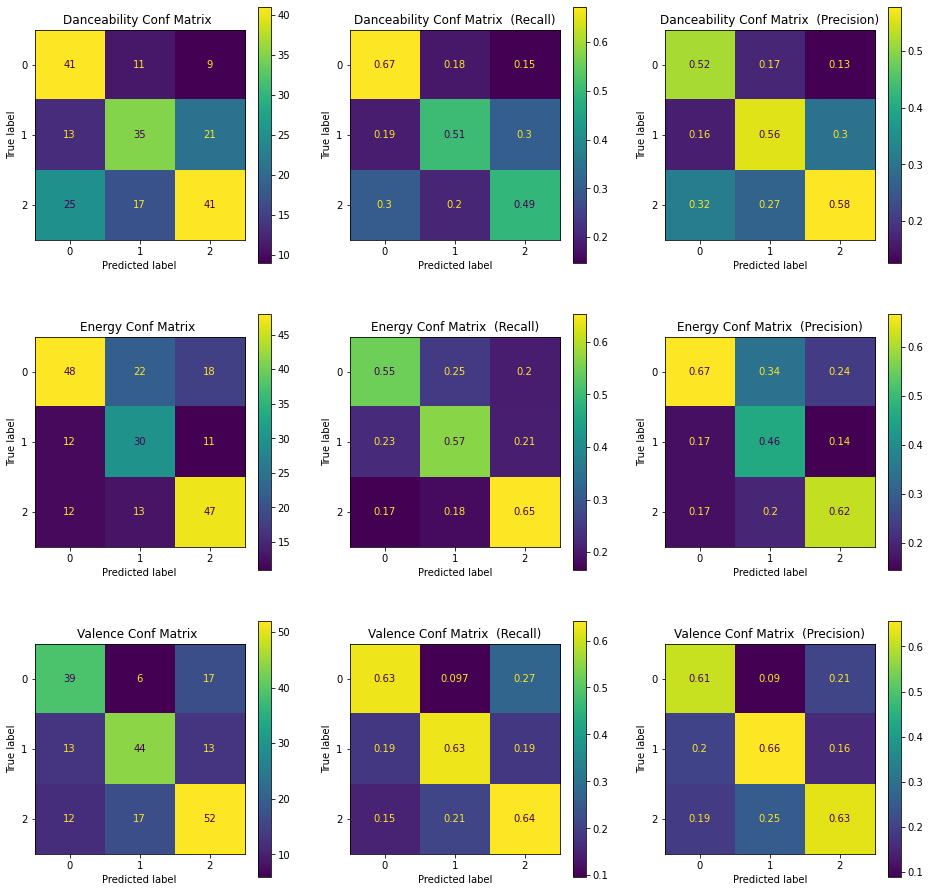

In [ ]:
plot_confusion_matrix_grid(y_test_d_int, y_pred_d, y_test_e_int, y_pred_e, y_test_v_int, y_pred_v)

## RNN

### Training Functions

In [ ]:
rnn_param_space = {'num_layers': [1, 2, 3], 'num_units': [128, 256, 512], 'bidirectional': [False, True]}

def create_rnn(num_layers, num_units, bidirectional):
  model_layers = [layers.Input((100, 15))]
  lstm = [layers.SimpleRNN(num_units, return_sequences=layer < num_layers - 1) for layer in range(num_layers)]
  if bidirectional:
    lstm = [layers.Bidirectional(layer) for layer in lstm]
  model_layers += lstm
  model_layers += [layers.Dense(3, activation='softmax')]
  return models.Sequential(model_layers)

def train_rnn(params, X, X_val, y, y_val, epochs=200, verbose=True):
  rnn = create_rnn(*params)
  rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  metrics = rnn.fit(
    X, y, validation_data=(X_val, y_val),
    batch_size=256,
    epochs=epochs,
    callbacks=[callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)],
    verbose=verbose,
  ).history
  y_pred = rnn.predict(X_val)
  return rnn, y_pred, metrics, max(metrics['val_accuracy'])

### Hyperparameter Search

Find optimal hyperparameters for danceability using 4-fold cross validation

In [ ]:
best_params_d = cross_validation(X_train_d, y_train_d, rnn_param_space, train_rnn)

============ Progress: 1/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: False

Average Accuracy Over 4-Folds: 49.41%
New Best?: True

============ Progress: 2/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: True

Average Accuracy Over 4-Folds: 54.25%
New Best?: True

============ Progress: 3/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: False

Average Accuracy Over 4-Folds: 50.47%
New Best?: False

============ Progress: 4/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: True

Average Accuracy Over 4-Folds: 54.6%
New Best?: True

============ Progress: 5/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: False

Average Accuracy Over 4-Folds: 49.88%
New Best?: False

============ Progress: 6/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: True

Average Accur

Find optimal hyperparameters for energy using 4-fold cross validation

In [ ]:
best_params_e = cross_validation(X_train_e, y_train_e, rnn_param_space, train_rnn)

============ Progress: 1/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: False

Average Accuracy Over 4-Folds: 51.3%
New Best?: True

============ Progress: 2/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: True

Average Accuracy Over 4-Folds: 58.49%
New Best?: True

============ Progress: 3/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: False

Average Accuracy Over 4-Folds: 53.89%
New Best?: False

============ Progress: 4/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: True

Average Accuracy Over 4-Folds: 57.43%
New Best?: False

============ Progress: 5/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: False

Average Accuracy Over 4-Folds: 52.24%
New Best?: False

============ Progress: 6/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: True

Average Accu

Find optimal hyperparameters for valence using 4-fold cross validation

In [ ]:
best_params_v = cross_validation(X_train_v, y_train_v, rnn_param_space, train_rnn)

============ Progress: 1/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: False

Average Accuracy Over 4-Folds: 48.7%
New Best?: True

============ Progress: 2/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: True

Average Accuracy Over 4-Folds: 57.9%
New Best?: True

============ Progress: 3/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: False

Average Accuracy Over 4-Folds: 52.0%
New Best?: False

============ Progress: 4/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: True

Average Accuracy Over 4-Folds: 58.02%
New Best?: True

============ Progress: 5/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: False

Average Accuracy Over 4-Folds: 51.42%
New Best?: False

============ Progress: 6/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: True

Average Accurac

### Training

Train danceability model using optimal hyperparameters

In [ ]:
rnn_d, y_pred_d, metrics_d, acc_d = train_rnn(best_params_d, X_train_d, X_test_d, y_train_d, y_test_d)

Epoch 1/200
4/4 [==============================] - 4s 469ms/step - loss: 1.4926 - accuracy: 0.3729 - val_loss: 1.1896 - val_accuracy: 0.4366
Epoch 2/200
4/4 [==============================] - 1s 312ms/step - loss: 0.8941 - accuracy: 0.5812 - val_loss: 1.1024 - val_accuracy: 0.4695
Epoch 3/200
4/4 [==============================] - 1s 343ms/step - loss: 0.6999 - accuracy: 0.7176 - val_loss: 1.0826 - val_accuracy: 0.5211
Epoch 4/200
4/4 [==============================] - 1s 312ms/step - loss: 0.5498 - accuracy: 0.8129 - val_loss: 1.1650 - val_accuracy: 0.4883
Epoch 5/200
4/4 [==============================] - 1s 322ms/step - loss: 0.4315 - accuracy: 0.8576 - val_loss: 1.2593 - val_accuracy: 0.4742
Epoch 6/200
4/4 [==============================] - 1s 330ms/step - loss: 0.3258 - accuracy: 0.8976 - val_loss: 1.3418 - val_accuracy: 0.4789
Epoch 7/200
4/4 [==============================] - 1s 318ms/step - loss: 0.2272 - accuracy: 0.9447 - val_loss: 1.4075 - val_accuracy: 0.4648
Epoch 8/200
4

Train energy model using optimal hyperparameters

In [ ]:
rnn_e, y_pred_e, metrics_e, acc_e = train_rnn(best_params_e, X_train_e, X_test_e, y_train_e, y_test_e)

Epoch 1/200
4/4 [==============================] - 2s 248ms/step - loss: 1.1638 - accuracy: 0.3447 - val_loss: 1.0387 - val_accuracy: 0.4319
Epoch 2/200
4/4 [==============================] - 1s 139ms/step - loss: 1.0043 - accuracy: 0.5212 - val_loss: 0.9997 - val_accuracy: 0.4930
Epoch 3/200
4/4 [==============================] - 1s 150ms/step - loss: 0.9207 - accuracy: 0.5941 - val_loss: 0.9646 - val_accuracy: 0.5352
Epoch 4/200
4/4 [==============================] - 1s 137ms/step - loss: 0.8368 - accuracy: 0.6435 - val_loss: 0.9481 - val_accuracy: 0.5399
Epoch 5/200
4/4 [==============================] - 1s 149ms/step - loss: 0.7726 - accuracy: 0.6906 - val_loss: 0.9584 - val_accuracy: 0.5540
Epoch 6/200
4/4 [==============================] - 1s 137ms/step - loss: 0.7235 - accuracy: 0.7200 - val_loss: 0.9458 - val_accuracy: 0.5728
Epoch 7/200
4/4 [==============================] - 1s 150ms/step - loss: 0.6650 - accuracy: 0.7376 - val_loss: 0.9754 - val_accuracy: 0.5822
Epoch 8/200
4

Train valence model using optimal hyperparameters

In [ ]:
rnn_v, y_pred_v, metrics_v, acc_v = train_rnn(best_params_v, X_train_v, X_test_v, y_train_v, y_test_v)

Epoch 1/200
4/4 [==============================] - 2s 255ms/step - loss: 1.1744 - accuracy: 0.3447 - val_loss: 1.0399 - val_accuracy: 0.4413
Epoch 2/200
4/4 [==============================] - 1s 147ms/step - loss: 0.9127 - accuracy: 0.5941 - val_loss: 0.9985 - val_accuracy: 0.5446
Epoch 3/200
4/4 [==============================] - 1s 151ms/step - loss: 0.7944 - accuracy: 0.6859 - val_loss: 1.0051 - val_accuracy: 0.5164
Epoch 4/200
4/4 [==============================] - 1s 148ms/step - loss: 0.6781 - accuracy: 0.7341 - val_loss: 1.0021 - val_accuracy: 0.5305
Epoch 5/200
4/4 [==============================] - 1s 148ms/step - loss: 0.5657 - accuracy: 0.8012 - val_loss: 1.0305 - val_accuracy: 0.5634
Epoch 6/200
4/4 [==============================] - 1s 149ms/step - loss: 0.5024 - accuracy: 0.8329 - val_loss: 1.1183 - val_accuracy: 0.5352
Epoch 7/200
4/4 [==============================] - 1s 151ms/step - loss: 0.4530 - accuracy: 0.8576 - val_loss: 1.0826 - val_accuracy: 0.5399
Epoch 8/200
4

Plot training metrics

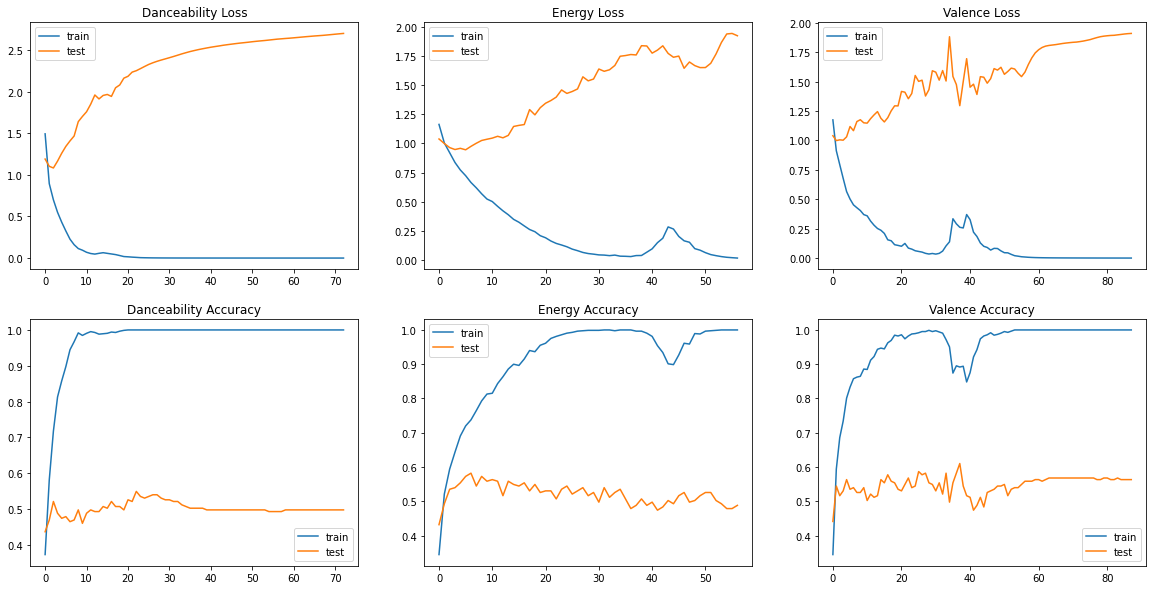

In [ ]:
plot_metrics(metrics_d, metrics_e, metrics_v)

### Results

Print accuracies

In [ ]:
print(f'Danceability Accuracy: {round(acc_d * 100, 2)}%')
print(f'Energy Accuracy: {round(acc_e * 100, 2)}%')
print(f'Valence Accuracy: {round(acc_v * 100, 2)}%')

Danceability Accuracy: 54.93%
Energy Accuracy: 58.22%
Valence Accuracy: 61.03%


Plot confusion matrices

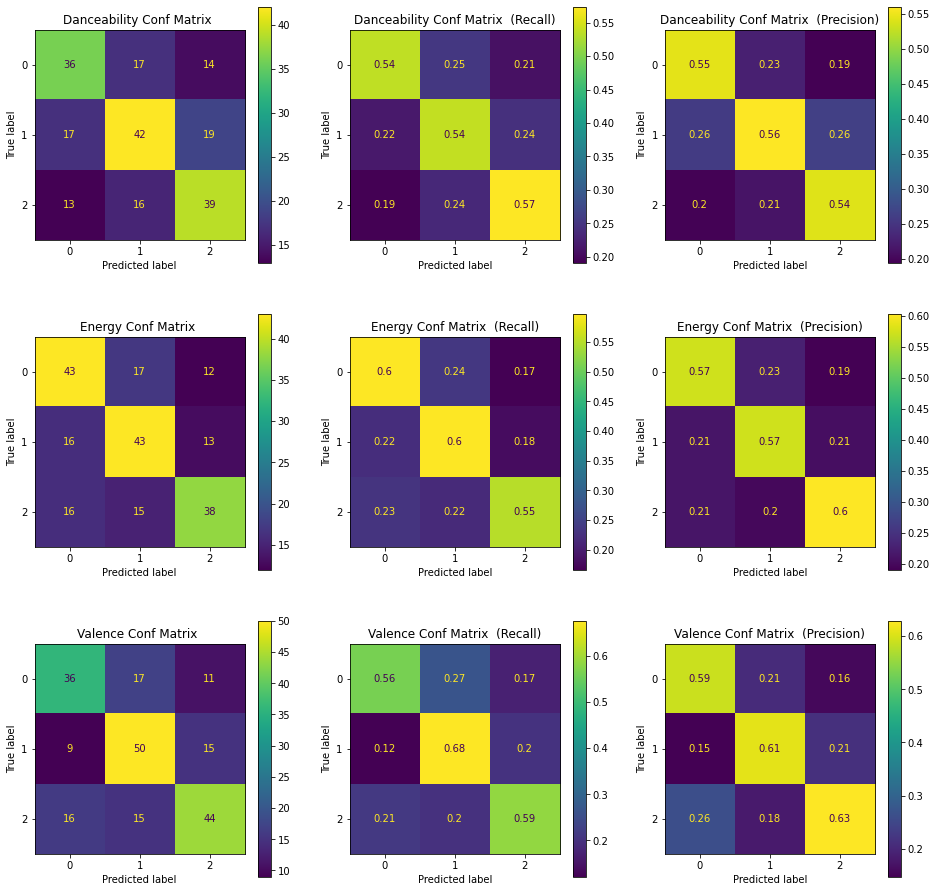

In [ ]:
plot_confusion_matrix_grid(y_test_d, y_pred_d, y_test_e, y_pred_e, y_test_v, y_pred_v, logits=True)

## LSTM

### Training Functions

In [ ]:
lstm_param_space = {
  'num_layers': [1, 2, 3],
  'num_units': [128, 256, 512],
  'bidirectional': [False, True]
}

def create_lstm(num_layers, num_units, bidirectional):
  model_layers = [layers.Input((100, 15))]
  lstm = [layers.LSTM(num_units, return_sequences=layer < num_layers - 1) for layer in range(num_layers)]
  if bidirectional:
    lstm = [layers.Bidirectional(layer) for layer in lstm]
  model_layers += lstm
  model_layers += [layers.Dense(3, activation='softmax')]
  return models.Sequential(model_layers)

def train_lstm(params, X, X_val, y, y_val, batch_size=256, epochs=200, verbose=True):
  lstm = create_lstm(*params)
  lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  metrics = lstm.fit(
    X, y, validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)],
    verbose=verbose,
  ).history
  y_pred = lstm.predict(X_val)
  return lstm, y_pred, metrics, max(metrics['val_accuracy'])

### Hyperparameter Search

Hyperparameter grid search on danceability using 4-fold cross validation

In [ ]:
best_params_d = cross_validation(X_train_d, y_train_d, lstm_param_space, train_lstm)

============ Progress: 1/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: False

Average Accuracy Over 4-Folds: 51.42%
New Best?: True

============ Progress: 2/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: True

Average Accuracy Over 4-Folds: 54.01%
New Best?: True

============ Progress: 3/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: False

Average Accuracy Over 4-Folds: 52.36%
New Best?: False

============ Progress: 4/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: True

Average Accuracy Over 4-Folds: 57.19%
New Best?: True

============ Progress: 5/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: False

Average Accuracy Over 4-Folds: 50.94%
New Best?: False

============ Progress: 6/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: True

Average Accu

Hyperparameter grid search on energy using 4-fold cross validation

In [ ]:
best_params_e = cross_validation(X_train_e, y_train_e, lstm_param_space, train_lstm)

============ Progress: 1/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: False

Average Accuracy Over 4-Folds: 57.67%
New Best?: True

============ Progress: 2/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: True

Average Accuracy Over 4-Folds: 60.02%
New Best?: True

============ Progress: 3/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: False

Average Accuracy Over 4-Folds: 60.5%
New Best?: True

============ Progress: 4/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: True

Average Accuracy Over 4-Folds: 61.2%
New Best?: True

============ Progress: 5/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: False

Average Accuracy Over 4-Folds: 58.73%
New Best?: False

============ Progress: 6/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: True

Average Accurac

Hyperparameter grid search on valence using 4-fold cross validation

In [ ]:
best_params_v = cross_validation(X_train_v, y_train_v, lstm_param_space, train_lstm)

============ Progress: 1/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: False

Average Accuracy Over 4-Folds: 55.54%
New Best?: True

============ Progress: 2/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 128
bidirectional: True

Average Accuracy Over 4-Folds: 60.5%
New Best?: True

============ Progress: 3/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: False

Average Accuracy Over 4-Folds: 55.54%
New Best?: False

============ Progress: 4/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 256
bidirectional: True

Average Accuracy Over 4-Folds: 60.97%
New Best?: True

============ Progress: 5/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: False

Average Accuracy Over 4-Folds: 57.78%
New Best?: False

============ Progress: 6/18 ============

>>>> Hyperparameters <<<<
num_layers: 1
num_units: 512
bidirectional: True

Average Accur

### Training

Train danceability model

In [ ]:
lstm_d, y_pred_d, metrics_d, acc_d = train_lstm(best_params_d, X_train_d, X_test_d, y_train_d, y_test_d)

Epoch 1/200
4/4 [==============================] - 15s 1s/step - loss: 1.1392 - accuracy: 0.3612 - val_loss: 1.0849 - val_accuracy: 0.3944
Epoch 2/200
4/4 [==============================] - 2s 378ms/step - loss: 1.0705 - accuracy: 0.4482 - val_loss: 1.0737 - val_accuracy: 0.3944
Epoch 3/200
4/4 [==============================] - 2s 393ms/step - loss: 1.0205 - accuracy: 0.4682 - val_loss: 1.0837 - val_accuracy: 0.4413
Epoch 4/200
4/4 [==============================] - 2s 379ms/step - loss: 1.0095 - accuracy: 0.5259 - val_loss: 1.0950 - val_accuracy: 0.4085
Epoch 5/200
4/4 [==============================] - 2s 389ms/step - loss: 0.9828 - accuracy: 0.4859 - val_loss: 1.0475 - val_accuracy: 0.4554
Epoch 6/200
4/4 [==============================] - 2s 392ms/step - loss: 0.9472 - accuracy: 0.5353 - val_loss: 1.0265 - val_accuracy: 0.4836
Epoch 7/200
4/4 [==============================] - 2s 381ms/step - loss: 0.9304 - accuracy: 0.5718 - val_loss: 1.0085 - val_accuracy: 0.4836
Epoch 8/200
4/4

Train energy model

In [ ]:
lstm_e, y_pred_e, metrics_e, acc_e = train_lstm(best_params_e, X_train_e, X_test_e, y_train_e, y_test_e)

Epoch 1/200
4/4 [==============================] - 9s 611ms/step - loss: 1.0926 - accuracy: 0.3647 - val_loss: 1.0646 - val_accuracy: 0.4648
Epoch 2/200
4/4 [==============================] - 0s 57ms/step - loss: 1.0336 - accuracy: 0.4918 - val_loss: 1.0408 - val_accuracy: 0.4601
Epoch 3/200
4/4 [==============================] - 0s 58ms/step - loss: 0.9930 - accuracy: 0.5341 - val_loss: 1.0489 - val_accuracy: 0.4319
Epoch 4/200
4/4 [==============================] - 0s 58ms/step - loss: 0.9720 - accuracy: 0.5259 - val_loss: 1.0179 - val_accuracy: 0.5164
Epoch 5/200
4/4 [==============================] - 0s 57ms/step - loss: 0.9572 - accuracy: 0.5388 - val_loss: 0.9969 - val_accuracy: 0.5164
Epoch 6/200
4/4 [==============================] - 0s 57ms/step - loss: 0.9107 - accuracy: 0.5588 - val_loss: 0.9774 - val_accuracy: 0.5305
Epoch 7/200
4/4 [==============================] - 0s 56ms/step - loss: 0.8867 - accuracy: 0.5859 - val_loss: 0.9743 - val_accuracy: 0.5258
Epoch 8/200
4/4 [==

Train valence model

In [ ]:
lstm_v, y_pred_v, metrics_v, acc_v = train_lstm(best_params_v, X_train_v, X_test_v, y_train_v, y_test_v)

Epoch 1/200
4/4 [==============================] - 12s 904ms/step - loss: 1.1086 - accuracy: 0.3553 - val_loss: 1.0703 - val_accuracy: 0.4742
Epoch 2/200
4/4 [==============================] - 0s 87ms/step - loss: 1.0603 - accuracy: 0.4329 - val_loss: 1.0393 - val_accuracy: 0.4789
Epoch 3/200
4/4 [==============================] - 0s 91ms/step - loss: 1.0138 - accuracy: 0.5106 - val_loss: 1.0023 - val_accuracy: 0.5023
Epoch 4/200
4/4 [==============================] - 0s 87ms/step - loss: 0.9747 - accuracy: 0.5224 - val_loss: 0.9891 - val_accuracy: 0.4930
Epoch 5/200
4/4 [==============================] - 0s 91ms/step - loss: 0.9447 - accuracy: 0.5306 - val_loss: 0.9796 - val_accuracy: 0.5070
Epoch 6/200
4/4 [==============================] - 0s 90ms/step - loss: 0.9054 - accuracy: 0.5741 - val_loss: 0.9708 - val_accuracy: 0.5399
Epoch 7/200
4/4 [==============================] - 0s 89ms/step - loss: 0.8667 - accuracy: 0.5988 - val_loss: 0.9865 - val_accuracy: 0.5493
Epoch 8/200
4/4 [=

Plot training metrics

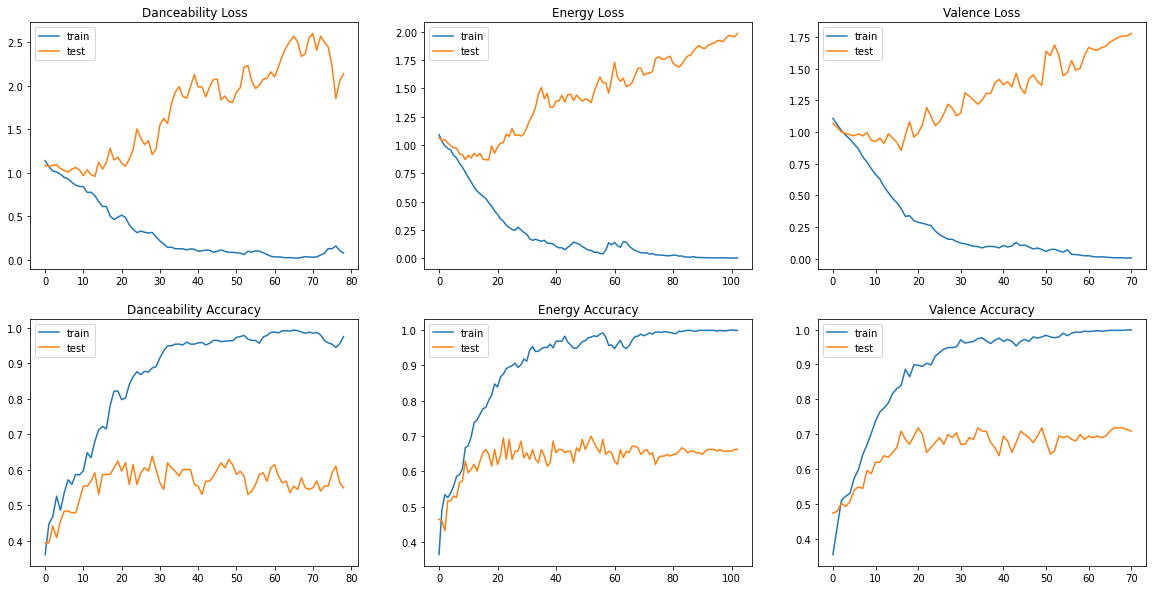

In [ ]:
plot_metrics(metrics_d, metrics_e, metrics_v)

### Results

Print accuracies

In [ ]:
print(f'Danceability Accuracy: {round(acc_d * 100, 2)}%')
print(f'Energy Accuracy: {round(acc_e * 100, 2)}%')
print(f'Valence Accuracy: {round(acc_v * 100, 2)}%')

Danceability Accuracy: 63.85%
Energy Accuracy: 69.95%
Valence Accuracy: 71.83%


Plot confusion matrices

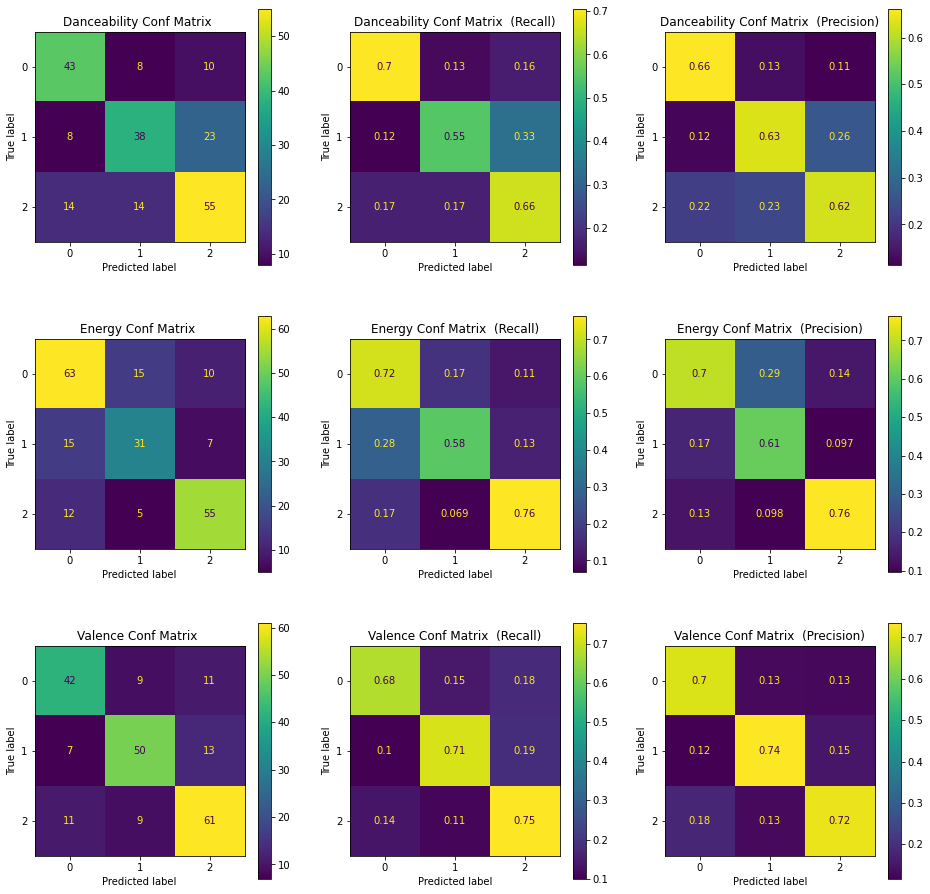

In [ ]:
plot_confusion_matrix_grid(y_test_d, y_pred_d, y_test_e, y_pred_e, y_test_v, y_pred_v, logits=True)

## LSTM (No Harmony)

### Preprocessing

In [ ]:
X_train_d_no_harmony = X_train_d[:,:,:3]
X_train_e_no_harmony = X_train_e[:,:,:3]
X_train_v_no_harmony = X_train_v[:,:,:3]

X_test_d_no_harmony = X_test_d[:,:,:3]
X_test_e_no_harmony = X_test_e[:,:,:3]
X_test_v_no_harmony = X_test_v[:,:,:3]

### Update Create LSTM Function

In [ ]:
def create_lstm(num_layers, num_units, bidirectional):
  model_layers = [layers.Input((100, 3))] # 3 instead of 15
  lstm = [layers.LSTM(num_units, return_sequences=layer < num_layers - 1) for layer in range(num_layers)]
  if bidirectional:
    lstm = [layers.Bidirectional(layer) for layer in lstm]
  model_layers += lstm
  model_layers += [layers.Dense(3, activation='softmax')]
  return models.Sequential(model_layers)

### Training

Train danceability model

In [ ]:
lstm_d_no_harmony, y_pred_d_no_harmony, metrics_d_no_harmony, acc_d_no_harmony = train_lstm(best_params_d, X_train_d_no_harmony, X_test_d_no_harmony, y_train_d, y_test_d)

Epoch 1/200
4/4 [==============================] - 9s 736ms/step - loss: 1.1002 - accuracy: 0.3412 - val_loss: 1.1075 - val_accuracy: 0.3380
Epoch 2/200
4/4 [==============================] - 1s 129ms/step - loss: 1.0808 - accuracy: 0.3847 - val_loss: 1.0899 - val_accuracy: 0.3662
Epoch 3/200
4/4 [==============================] - 1s 128ms/step - loss: 1.0773 - accuracy: 0.3882 - val_loss: 1.0909 - val_accuracy: 0.3709
Epoch 4/200
4/4 [==============================] - 1s 129ms/step - loss: 1.0789 - accuracy: 0.3800 - val_loss: 1.0936 - val_accuracy: 0.3756
Epoch 5/200
4/4 [==============================] - 0s 125ms/step - loss: 1.0746 - accuracy: 0.3882 - val_loss: 1.0974 - val_accuracy: 0.3568
Epoch 6/200
4/4 [==============================] - 1s 131ms/step - loss: 1.0739 - accuracy: 0.4012 - val_loss: 1.0946 - val_accuracy: 0.4554
Epoch 7/200
4/4 [==============================] - 1s 126ms/step - loss: 1.0664 - accuracy: 0.4141 - val_loss: 1.0891 - val_accuracy: 0.3756
Epoch 8/200
4

Train energy model

In [ ]:
lstm_e_no_harmony, y_pred_e_no_harmony, metrics_e_no_harmony, acc_e_no_harmony = train_lstm(best_params_e, X_train_e_no_harmony, X_test_e_no_harmony, y_train_e, y_test_e)

Epoch 1/200
4/4 [==============================] - 4s 369ms/step - loss: 1.1001 - accuracy: 0.3200 - val_loss: 1.0957 - val_accuracy: 0.3756
Epoch 2/200
4/4 [==============================] - 0s 39ms/step - loss: 1.0918 - accuracy: 0.3565 - val_loss: 1.0975 - val_accuracy: 0.3615
Epoch 3/200
4/4 [==============================] - 0s 38ms/step - loss: 1.0893 - accuracy: 0.3506 - val_loss: 1.0940 - val_accuracy: 0.3662
Epoch 4/200
4/4 [==============================] - 0s 30ms/step - loss: 1.0837 - accuracy: 0.3871 - val_loss: 1.0933 - val_accuracy: 0.3709
Epoch 5/200
4/4 [==============================] - 0s 28ms/step - loss: 1.0845 - accuracy: 0.3765 - val_loss: 1.0897 - val_accuracy: 0.3756
Epoch 6/200
4/4 [==============================] - 0s 27ms/step - loss: 1.0801 - accuracy: 0.4176 - val_loss: 1.0904 - val_accuracy: 0.4319
Epoch 7/200
4/4 [==============================] - 0s 26ms/step - loss: 1.0795 - accuracy: 0.4118 - val_loss: 1.0894 - val_accuracy: 0.4225
Epoch 8/200
4/4 [==

Train valence model

In [ ]:
lstm_v_no_harmony, y_pred_v_no_harmony, metrics_v_no_harmony, acc_v_no_harmony = train_lstm(best_params_v, X_train_v_no_harmony, X_test_v_no_harmony, y_train_v, y_test_v)

Epoch 1/200
4/4 [==============================] - 4s 307ms/step - loss: 1.0982 - accuracy: 0.3588 - val_loss: 1.0995 - val_accuracy: 0.3662
Epoch 2/200
4/4 [==============================] - 0s 50ms/step - loss: 1.0853 - accuracy: 0.3941 - val_loss: 1.0917 - val_accuracy: 0.3709
Epoch 3/200
4/4 [==============================] - 0s 48ms/step - loss: 1.0868 - accuracy: 0.3988 - val_loss: 1.0958 - val_accuracy: 0.4366
Epoch 4/200
4/4 [==============================] - 0s 47ms/step - loss: 1.0772 - accuracy: 0.4165 - val_loss: 1.0842 - val_accuracy: 0.4366
Epoch 5/200
4/4 [==============================] - 0s 48ms/step - loss: 1.0774 - accuracy: 0.4141 - val_loss: 1.0830 - val_accuracy: 0.4366
Epoch 6/200
4/4 [==============================] - 0s 47ms/step - loss: 1.0757 - accuracy: 0.4212 - val_loss: 1.0838 - val_accuracy: 0.4131
Epoch 7/200
4/4 [==============================] - 0s 46ms/step - loss: 1.0712 - accuracy: 0.4176 - val_loss: 1.0878 - val_accuracy: 0.4038
Epoch 8/200
4/4 [==

Plot training metrics

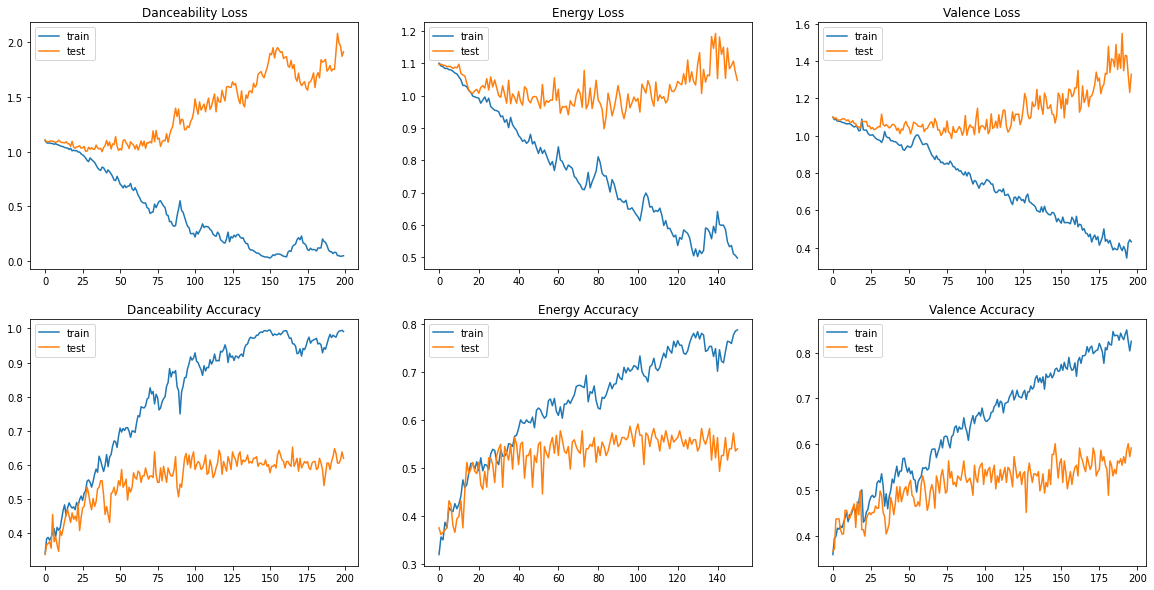

In [ ]:
plot_metrics(metrics_d_no_harmony, metrics_e_no_harmony, metrics_v_no_harmony)

### Results

Print accuracies

In [ ]:
print(f'Danceability Accuracy: {round(acc_d_no_harmony * 100, 2)}%')
print(f'Energy Accuracy: {round(acc_e_no_harmony * 100, 2)}%')
print(f'Valence Accuracy: {round(acc_v_no_harmony * 100, 2)}%')

Danceability Accuracy: 65.26%
Energy Accuracy: 59.15%
Valence Accuracy: 60.09%


Plot confusion matrices

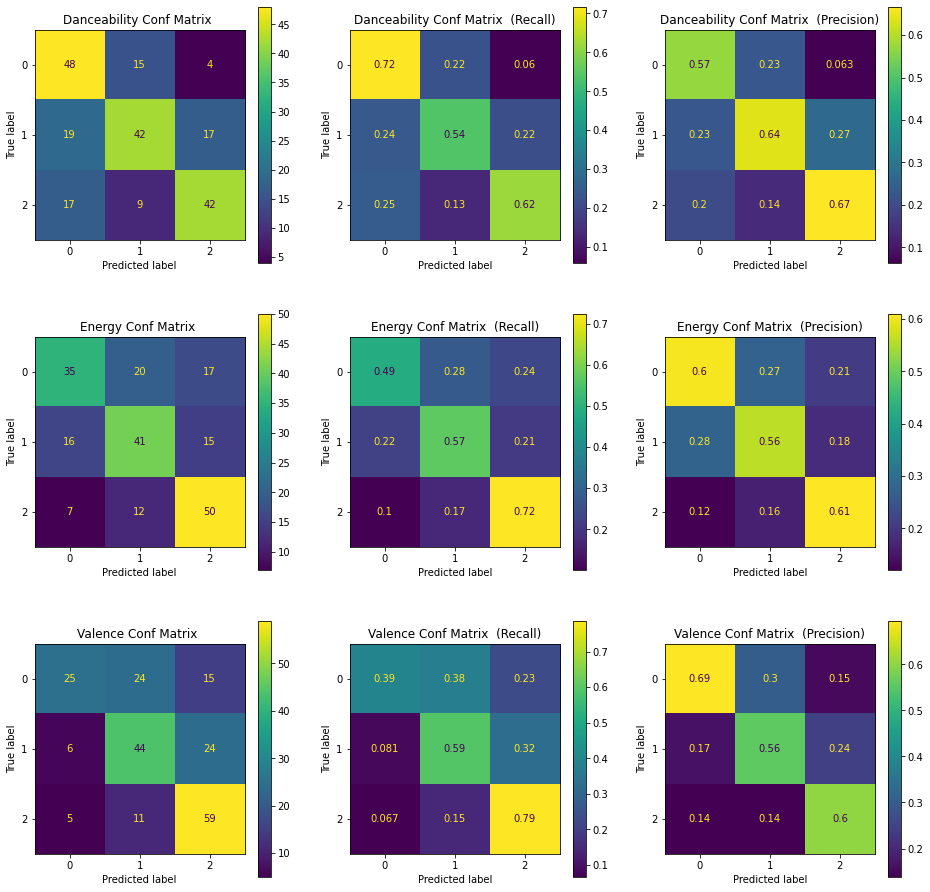

In [ ]:
plot_confusion_matrix_grid(y_test_d, y_pred_d_no_harmony, y_test_e, y_pred_e_no_harmony, y_test_v, y_pred_v_no_harmony, logits=True)

## Transformer

Imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import time
import pdb
import math
from itertools import cycle

Construct DataLoaders

In [ ]:
X_train_d_loader = DataLoader(X_train_d_no_harmony, batch_size = 32)
X_train_e_loader = DataLoader(X_train_e_no_harmony, batch_size = 32)
X_train_v_loader = DataLoader(X_train_v_no_harmony, batch_size = 32)

In [ ]:
y_train_d_loader = DataLoader(y_train_d, batch_size = 32)
y_train_e_loader = DataLoader(y_train_e, batch_size = 32)
y_train_v_loader = DataLoader(y_train_v, batch_size = 32)

In [ ]:
X_test_d_loader = DataLoader(X_test_d_no_harmony, batch_size = 32)
X_test_e_loader = DataLoader(X_test_e_no_harmony, batch_size = 32)
X_test_v_loader = DataLoader(X_test_v_no_harmony, batch_size = 32)

In [ ]:
y_test_d_loader = DataLoader(y_test_d, batch_size = 32)
y_test_e_loader = DataLoader(y_test_e, batch_size = 32)
y_test_v_loader = DataLoader(y_test_v, batch_size = 32)

"Embedding," Which is a Linear Layer

In [ ]:
class Embedder(nn.Module):
  def __init__(self, atts_length, d_model):
    super().__init__()
    
    # Attributes length is 3 for our preprocessing
    self.fc = nn.Linear(atts_length, d_model)

  def forward(self, x):
    return self.fc(x.float())

Positional Encoder

In [ ]:
class PositionalEncoder(nn.Module):
  
  def __init__(self, d_model, max_seq_len = 100):
    super().__init__()
    self.d_model = d_model

    # create pe matrix
    pe = torch.zeros(max_seq_len, d_model)
    for pos in range(max_seq_len):
      for i in range (0, d_model, 2):
        pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
        pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i) / d_model)))

    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe)

  def forward(self, x):
    
    # add position info to embedding
    x = x * math.sqrt(self.d_model)

    # add constant to embedding
    seq_len = x.shape[1]
    x = x + Variable(self.pe[:,:seq_len], requires_grad = False)

    return x

Output Layer

In [ ]:
class Output(nn.Module):
  def __init__(self, seq_len, d_model, hidden_size = 100):
    super().__init__()
    
    self.d_model = d_model
    self.hidden_size = hidden_size
    
    self.fc1 = nn.Linear(seq_len * d_model, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 3)

    self.relu = nn.ReLU()

  def forward(self, x):
    
    # used when decoder is used
    # fc1 = nn.Linear(self.d_model * x.shape[0], self.hidden_size)
    
    # Flatten, excluding batch dim
    x = x.reshape(x.shape[0], -1)

    x = self.fc1(x)
    #x = self.relu(x)
    x = self.fc2(x)
    #x = self.relu(x)

    return x

Multi-Head Attention

In [ ]:
class MHA(nn.Module):
  def __init__(self, heads, d_model, dropout = 0.1):
    super().__init__()
    
    # Number of heads running attention concurrently
    self.heads = heads

    # Model dimensionality: hidden dim size of value, key, query
    self.d_model = d_model

    # Model dimensionality per head (V,K,Q split between heads along this dim)
    self.d_k = d_model // heads

    # Linear layers for producing V,K,Q
    self.v_fc = nn.Linear(d_model, d_model)
    self.k_fc = nn.Linear(d_model, d_model)
    self.q_fc = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(p = dropout)

    # Linear layer for producing final prediction
    self.out = nn.Linear(d_model, d_model)

  def forward(self, q, k, v):

    batch_size = q.shape[0]

    # Calc value, key, query, as linear layer outputs
    v = self.v_fc(v).view(batch_size, -1, self.heads, self.d_k)
    k = self.k_fc(k).view(batch_size, -1, self.heads, self.d_k)
    q = self.q_fc(q).view(batch_size, -1, self.heads, self.d_k)

    k, q, v = k.transpose(1,2), q.transpose(1,2), v.transpose(1,1)

    # Calculate attention (mask will work differently here!)
    scores = attention(q, k, v, self.d_k)

    # Concat heads and put through output layer to make predictions
    concat = scores.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)
    output = self.out(concat)

    return output

Attention

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    ## This will likely need to be changed

    # Query * Key
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

    # Masking (not implemented)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    # Preparing for Value calc
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
    
    # Score * Value (how well does each query align w/each key)
    output = torch.matmul(scores, v.transpose(2,1))

    return output

Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_hidden= 2048, dropout = 0.1):
    super().__init__()

    # Normal feed-forward net . . . will output d_model
    self.fc1 = nn.Linear(d_model, d_hidden)
    self.dropout = nn.Dropout(p = dropout)
    self.fc2 = nn.Linear(d_hidden, d_model)

    self.relu = nn.ReLU()

  def forward(self, x):

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x

Normalization

In [ ]:
class Norm(nn.Module):
  def __init__(self, d_model, eps = 1e-6):

    super().__init__()

    self.d_model = d_model

    # Initialize learnable normalization parameters alpha and beta
    self.alpha = nn.Parameter(torch.ones(self.d_model))
    self.beta = nn.Parameter(torch.zeros(self.d_model))
    self.eps = eps

  def forward(self, x):
    
    # Subtract mean to get deviation, devide by stdev and add bias beta
    x = self.alpha * (x - x.mean(dim = -1, keepdim = True)) / (x.std(dim = -1, keepdim = True) + self.eps) + self.beta

    return x

Encoder Layer & Encoder

In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self, d_model, heads, dropout = 0.5):
    super().__init__()

    # Network Layers
    self.attn = MHA(heads, d_model)
    self.ff = FeedForward(d_model)

    # Normalization & Dropout
    self.n1 = Norm(d_model)
    self.n2 = Norm(d_model)
    self.d1 = nn.Dropout(dropout)
    self.d2 = nn.Dropout(dropout)

  def forward(self, x, mask = None):
    
    # Input normalization
    x2 = self.n1(x)

    # Attention Layer (query, key, value all start the same) with residual addition
    x3 = self.attn(x2, x2, x2)
    x = x + self.d1(x3)

    # Attention normalization
    x2 = self.n2(x)

    # Feedforward Layer with residual addition
    x3 = self.ff(x2)
    x = x + self.d2(x3)

    return x

In [ ]:
class Encoder(nn.Module):

  def __init__(self, size, d_model, n, heads):
    super().__init__()

    # Define positional encoder
    self.pe = PositionalEncoder(d_model)

    # Number of encoders in the encoder stack
    self.n = n

    # Midi embedding (different from normal NLP embedding)
    self.embed = Embedder(size, d_model)

    # Generate stack of "n" encoder layers
    self.layers = get_clones(EncoderLayer(d_model, heads), n)

    # Normalization layer
    self.norm = Norm(d_model)

  def forward(self, x, mask = None, verbose = False):

    if verbose:
        print("encoding . . .")

    # Embed note attributes
    x = self.embed(x)

    # Add position information
    x = self.pe(x)

    # Send value through encoder stack
    for i in range(n):
      x = self.layers[i](x)

    # Normalize output
    x = self.norm(x)

    return x

Decoder Layer & Decoder

In [ ]:
class DecoderLayer(nn.Module):

  def __init__(self, d_model, heads, dropout = 0.5):
    super().__init__()

    # Network Layers (two attentions, one using encoder values for key value)
    self.attn1 = MHA(heads, d_model)
    self.attn2 = MHA(heads, d_model)
    self.ff = FeedForward(d_model)

    # Normalization & Dropout
    self.n1 = Norm(d_model)
    self.n2 = Norm(d_model)
    self.n3 = Norm(d_model)
    self.d1 = nn.Dropout(dropout)
    self.d2 = nn.Dropout(dropout)
    self.d3 = nn.Dropout(dropout)

  def forward(self, x, e_outputs, src_mask = None, trg_mask = None):

    # Input normalization
    x2 = self.n1(x)

    # Attention Layer (query, key, value all start the same) with residual addition
    x3 = self.attn1(x2, x2, x2)
    x = x + self.d1(x3)

    # Attention normalization
    x2 = self.n2(x)

    # Attention Layer (incorperates encoder outputs) with residual addition
    x3 = self.attn2(x2, e_outputs, e_outputs)
    x = x + self.d2(x3)

    # Attention normalization
    x2 = self.n3(x)

    # Feedforward Layer with residual addition
    x3 = self.ff(x2)
    x = x + self.d2(x3)

    return x

In [ ]:
class Decoder(nn.Module):

  def __init__(self, size, d_model, n, heads):
    super().__init__()

    # Number of encoders in the encoder stack
    self.n = n

    # Midi embedding (different from normal NLP embedding)
    self.embed = Embedder(size, d_model)

    # Generate stack of "n" decoder layers
    self.layers = get_clones(DecoderLayer(d_model, heads), n)

    # Normalization layer
    self.norm = Norm(d_model)

  def forward(self, x, e_outputs, src_mask = None, trg_mask = None, verbose = False):
    
    if verbose:
      print("decoding . . .")

    # Embed note attributes
    x = self.embed(x)

    # Send value through decoder stack
    for i in range(n):
      x = self.layers[i](x, e_outputs)

    # Normalize output
    x = self.norm(x)

    return x

Cloning Method

In [ ]:
def get_clones(module, n):
  ''' Use list comprehension to create stacks of networks layers '''
  return nn.ModuleList([copy.deepcopy(module) for i in range(n)])

Transformer (Full Implemented)

In [ ]:
class Transformer(nn.Module):

  def __init__(self, src_att, trg_att, d_model, N, heads):
    super().__init__()

    # Source attributes are initial three or three + harmony infomation (12 tones, one-hot). Target should always be one
    self.encoder = Encoder(src_att, d_model, n, heads)
    self.decoder = Decoder(trg_att, d_model, n, heads)
    self.out = Output(100, d_model)

    # get lengths of source, target seqs
    self.src_att = src_att
    self.trg_att = trg_att

  def forward(self, src, trg, verbose = False):
    
    if verbose:
      print('starting forward pass')

    e_outputs = self.encoder(src)
    #d_outputs = self.decoder(trg, e_outputs)
    output = self.out(e_outputs)

    if verbose:
      print('finishing forward pass')

    return output

Training

In [ ]:
def train_model(model, X_train_loader, y_train_loader, X_test_loader, y_test_loader, epochs):
    
    model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    loss_avg = 0
    n_correct = 0
    n_total = 0

    # Track train, test loss, accuracy
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    test_loss_list = []
    
    for epoch in range(epochs):
       
        for i, (batch, labels) in enumerate(zip(cycle(X_train_loader), y_train_loader)):
            src = batch
            trg = labels
            
            # src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg)
            
            optim.zero_grad()
            
            #pdb.set_trace()
            loss = F.cross_entropy(preds, trg)
            #pdb.set_trace()
            loss.backward()
            #pdb.set_trace()
            optim.step()
            #pdb.set_trace()    
            total_loss += loss.data
            #pdb.set_trace()

            # Ordinal model predictions
            pred_classes = torch.argmax(preds, dim = 1)
            trg_classes = torch.argmax(trg, dim = 1)
            #pdb.set_trace()

            # Compile correct/incorrect for accuracy calc
            n_correct += sum(pred_classes == trg_classes)
            n_total += batch.shape[0]

        train_acc = n_correct/n_total
        train_loss = total_loss/i

        # Check test accuracy
        test_loss, test_acc, _, _ = test_model(model, X_test_loader, y_test_loader, verbose = False)

        print("time = %dm, epoch %d, loss/batch = %.3f, training accuracy = %.3f, test accuracy = %0.3f, %ds/epoch" % ((time.time() - start) // 60,\
        epoch + 1, train_loss, train_acc, test_acc, time.time() - temp))

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        total_loss = 0
        n_correct = 0
        n_total = 0

        temp = time.time()

    return train_acc_list, train_loss_list, test_acc_list, test_loss_list    

In [ ]:
def test_model(model, X_test_loader, y_test_loader, verbose = True):

  model.eval()

  n_correct = 0
  n_total = 0
  total_loss = 0

  pred_classes_list = []
  trg_classes_list = []

  for i, (batch, labels) in enumerate(zip(cycle(X_test_loader), y_test_loader)):
    src = batch
    trg = labels

    # Probabilistic model predictions
    preds = model(src, trg)

    # CE Loss
    loss = F.cross_entropy(preds, trg)
    total_loss += loss.data

    # Ordinal model predictions
    pred_classes = torch.argmax(preds, dim = 1)
    trg_classes = torch.argmax(trg, dim = 1)
    
    pred_classes_list = pred_classes_list + pred_classes.toList()
    trg_classes_list = trg_classes_list + trg_classes.toList()

    # Compile correct/incorrect for accuracy calc
    n_correct += sum(pred_classes == trg_classes)
    n_total += batch.shape[0]
    #pdb.set_trace()

  accuracy = n_correct/n_total
  avg_loss = total_loss/i

  if verbose:
    print(f"Average loss: {avg_loss}")
    print(f"Accuracy: {accuracy}")

  return avg_loss, accuracy, pred_classes_list, trg_classes_list

Energy (~80 mins)

In [ ]:
X_train = X_train_e

# Define hyperparameters
d_model, heads, n = 64,8,4
src_att = X_train.shape[2]
trg_att = 3

# Build model
eng_model = Transformer(src_att, trg_att, d_model, n, heads)

# Initialize model
for p in eng_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Construct Optimizer
optim = torch.optim.Adam(eng_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_acc_list_e, train_loss_list_e, test_acc_list_e, test_loss_list_e \
= train_model(eng_model, X_train_e_loader, y_train_e_loader, X_test_e_loader, y_test_e_loader, epochs = 200)

time = 0m, epoch 1, loss/batch = 1.826, training accuracy = 0.360, test accuracy = 0.371, 28s/epoch
time = 0m, epoch 2, loss/batch = 1.115, training accuracy = 0.449, test accuracy = 0.423, 23s/epoch
time = 1m, epoch 3, loss/batch = 1.006, training accuracy = 0.519, test accuracy = 0.488, 25s/epoch
time = 1m, epoch 4, loss/batch = 0.937, training accuracy = 0.576, test accuracy = 0.512, 24s/epoch
time = 2m, epoch 5, loss/batch = 0.890, training accuracy = 0.595, test accuracy = 0.531, 23s/epoch
time = 2m, epoch 6, loss/batch = 0.822, training accuracy = 0.635, test accuracy = 0.563, 23s/epoch
time = 2m, epoch 7, loss/batch = 0.769, training accuracy = 0.679, test accuracy = 0.535, 24s/epoch
time = 3m, epoch 8, loss/batch = 0.737, training accuracy = 0.691, test accuracy = 0.521, 24s/epoch
time = 3m, epoch 9, loss/batch = 0.713, training accuracy = 0.694, test accuracy = 0.516, 24s/epoch
time = 4m, epoch 10, loss/batch = 0.710, training accuracy = 0.692, test accuracy = 0.498, 23s/epoch

Danceability (~80 mins)

In [ ]:
X_train = X_train_d

# Define hyperparameters
d_model, heads, n = 64,8,4
src_att = X_train.shape[2]
trg_att = 3

# Build model
dnc_model = Transformer(src_att, trg_att, d_model, n, heads)

# Initialize model
for p in dnc_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Construct Optimizer
optim = torch.optim.Adam(dnc_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_acc_list_d, train_loss_list_d, test_acc_list_d, test_loss_list_d \
= train_model(dnc_model, X_train_d_loader, y_train_d_loader, X_test_d_loader, y_test_d_loader, epochs = 200)

time = 0m, epoch 1, loss/batch = 1.560, training accuracy = 0.371, test accuracy = 0.357, 28s/epoch
time = 0m, epoch 2, loss/batch = 1.256, training accuracy = 0.366, test accuracy = 0.357, 24s/epoch
time = 1m, epoch 3, loss/batch = 1.155, training accuracy = 0.418, test accuracy = 0.362, 23s/epoch
time = 1m, epoch 4, loss/batch = 1.091, training accuracy = 0.447, test accuracy = 0.371, 24s/epoch
time = 2m, epoch 5, loss/batch = 1.082, training accuracy = 0.460, test accuracy = 0.371, 24s/epoch
time = 2m, epoch 6, loss/batch = 1.037, training accuracy = 0.486, test accuracy = 0.371, 24s/epoch
time = 2m, epoch 7, loss/batch = 0.998, training accuracy = 0.502, test accuracy = 0.376, 24s/epoch
time = 3m, epoch 8, loss/batch = 0.952, training accuracy = 0.536, test accuracy = 0.385, 24s/epoch
time = 3m, epoch 9, loss/batch = 0.913, training accuracy = 0.561, test accuracy = 0.394, 24s/epoch
time = 4m, epoch 10, loss/batch = 0.876, training accuracy = 0.588, test accuracy = 0.376, 24s/epoch

Valence (~80 mins)

In [ ]:
X_train = X_train_v

# Define hyperparameters
d_model, heads, n = 64,8,4
src_att = X_train.shape[2]
trg_att = 3

# Build model
val_model = Transformer(src_att, trg_att, d_model, n, heads)

# Initialize model
for p in val_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Construct Optimizer
optim = torch.optim.Adam(val_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_acc_list_v, train_loss_list_v, test_acc_list_v, test_loss_list_v \
= train_model(val_model, X_train_v_loader, y_train_v_loader, X_test_v_loader, y_test_v_loader, epochs = 200)

time = 0m, epoch 1, loss/batch = 1.688, training accuracy = 0.344, test accuracy = 0.399, 28s/epoch
time = 0m, epoch 2, loss/batch = 1.128, training accuracy = 0.435, test accuracy = 0.413, 24s/epoch
time = 1m, epoch 3, loss/batch = 1.106, training accuracy = 0.448, test accuracy = 0.418, 24s/epoch
time = 1m, epoch 4, loss/batch = 1.010, training accuracy = 0.513, test accuracy = 0.418, 24s/epoch
time = 2m, epoch 5, loss/batch = 0.962, training accuracy = 0.545, test accuracy = 0.432, 24s/epoch
time = 2m, epoch 6, loss/batch = 0.903, training accuracy = 0.586, test accuracy = 0.479, 23s/epoch
time = 2m, epoch 7, loss/batch = 0.848, training accuracy = 0.612, test accuracy = 0.516, 23s/epoch
time = 3m, epoch 8, loss/batch = 0.805, training accuracy = 0.645, test accuracy = 0.521, 23s/epoch
time = 3m, epoch 9, loss/batch = 0.774, training accuracy = 0.665, test accuracy = 0.479, 23s/epoch
time = 4m, epoch 10, loss/batch = 0.725, training accuracy = 0.700, test accuracy = 0.521, 24s/epoch

Graphics

In [ ]:
def plot_metrics(metrics_d, metrics_e, metrics_v):
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  axs = [[axs[0][i], axs[1][i]] for i in range(3)]
  metrics = [
    ('Danceability', metrics_d),
    ('Energy', metrics_e),
    ('Valence', metrics_v)
  ]

  for (target_name, target_metrics), (ax1, ax2) in zip(metrics, axs):
    ax1.set_title(f'{target_name} Loss')
    ax1.plot(target_metrics['loss'],)
    ax1.plot(target_metrics['val_loss'])
    ax1.legend(['train', 'test'])

    ax2.set_title(f'{target_name} Accuracy')
    ax2.plot(target_metrics['accuracy'])
    ax2.plot(target_metrics['val_accuracy'])
    ax2.legend(['train', 'test'])

  plt.show()


In [ ]:
# Reformat accuracy, loss, lists into dataframes

metrics_d = pd.DataFrame(columns = ["loss", "val_loss", "accuracy", "val_accuracy"])
metrics_e = pd.DataFrame(columns = ["loss", "val_loss", "accuracy", "val_accuracy"])
metrics_v = pd.DataFrame(columns = ["loss", "val_loss", "accuracy", "val_accuracy"])

metrics_d["loss"], metrics_d["val_loss"], metrics_d["accuracy"], metrics_d["val_accuracy"] \
= train_loss_list_d, test_loss_list_d, train_acc_list_d, test_acc_list_d

metrics_e["loss"], metrics_e["val_loss"], metrics_e["accuracy"], metrics_e["val_accuracy"] \
= train_loss_list_e, test_loss_list_e, train_acc_list_e, test_acc_list_e

metrics_v["loss"], metrics_v["val_loss"], metrics_v["accuracy"], metrics_v["val_accuracy"] \
= train_loss_list_v, test_loss_list_v, train_acc_list_v, test_acc_list_v

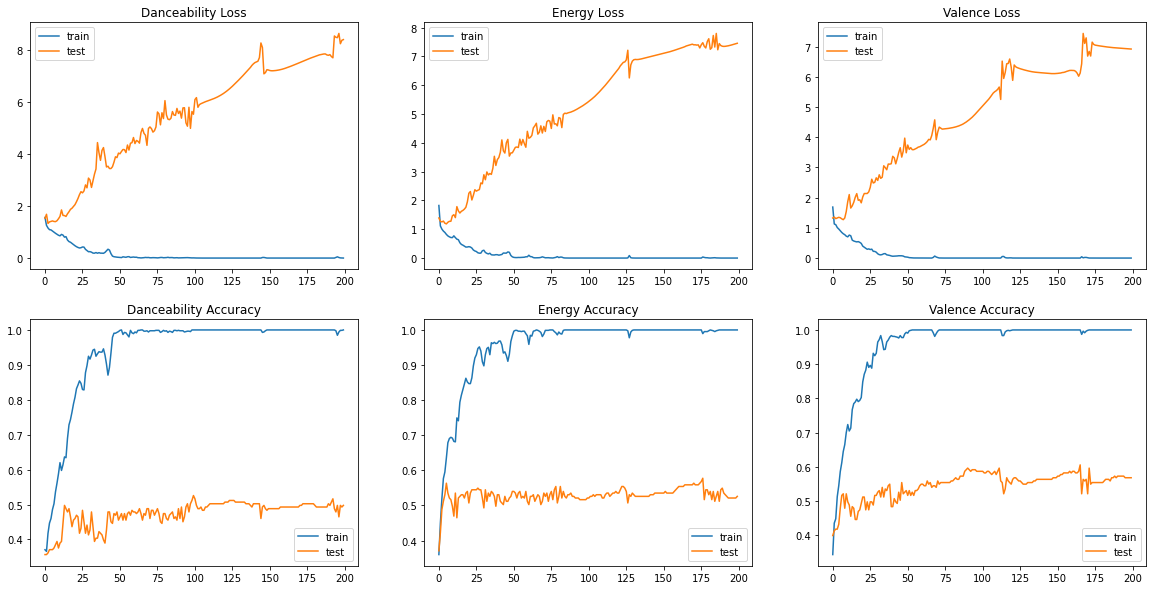

In [ ]:
plot_metrics(metrics_d, metrics_e, metrics_v)

In [ ]:
def plot_confusion_matrix_grid(y_true_d, y_pred_d, y_true_e, y_pred_e, y_true_v, y_pred_v, logits=False):
  fig, axs = plt.subplots(3, 3, figsize=(16, 16))

  if logits:
    y_true_d = np.argmax(y_true_d, axis=1)
    y_true_e = np.argmax(y_true_e, axis=1)
    y_true_v = np.argmax(y_true_v, axis=1)
    y_pred_d = np.argmax(y_pred_d, axis=1)
    y_pred_e = np.argmax(y_pred_e, axis=1)
    y_pred_v = np.argmax(y_pred_v, axis=1)

  data = [
    ('Danceability', y_true_d, y_pred_d),
    ('Energy', y_true_e, y_pred_e),
    ('Valence', y_true_v, y_pred_v)
  ]

  for (target_name, y_true, y_pred), ax_row in zip(data, axs):
    for normalize, ax in zip([None, 'true', 'pred'], ax_row):
      cmat = confusion_matrix(y_true, y_pred, normalize=normalize)
      cmat_display = ConfusionMatrixDisplay(cmat)
      cmat_display.plot(ax=ax)
      cmat_type = ' (Precision)' if normalize == 'pred' else (' (Recall)' if normalize == 'true' else '')
      ax.set_title(f'{target_name} Conf Matrix {cmat_type}')
  plt.show()

In [ ]:
# Get lists of all test predictions for all tasks
_, _, d_pred, d_trg = test_model(dnc_model, X_test_d_loader, y_test_d_loader, verbose = True)
_, _, e_pred, e_trg = test_model(eng_model, X_test_e_loader, y_test_e_loader, verbose = True)
_, _, v_pred, v_trg = test_model(val_model, X_test_v_loader, y_test_v_loader, verbose = True)

In [ ]:
plot_confusion_matrix_grid(d_trg, d_pred, e_trg, e_pred, v_trg, v_pred)

# Results

| Model | Target | Accuracy | Best |
| ----- | ------ | -------- | ---- |
| Logistic Regression | Danceability | 54.93% | - |
| Logistic Regression | Energy | 58.69% | - |
| Logistic Regression | Valence | 63.38% | - |
| RNN | Danceability | 54.93% | - |
| RNN | Energy | 58.22% | - |
| RNN | Valence | 61.03% | - |
| LSTM | Danceability | 63.85% | - |
| LSTM | Energy | 69.95% | ✓ |
| LSTM | Valence | 71.83% | ✓ |
| LSTM (No Harmony) | Danceability | 65.26% | ✓ |
| LSTM (No Harmony) | Energy | 59.15% | - |
| LSTM (No Harmony) | Valence | 60.09% | - |
| Transformer | Danceability | 49.84% | - |
| Transformer | Energy | 52.62% | - |
| Transformer | Valence | 56.80% | - |

Select best models

In [ ]:
model_d = lstm_d_no_harmony
model_e = lstm_e
model_v = lstm_v

Play random song classified as **not danceable**

In [ ]:
random_song(model_d, 0, X_test_d_no_harmony, y_test_d)

Play random song classified as **somewhat danceable**

In [ ]:
random_song(model_d, 1, X_test_d_no_harmony, y_test_d)

Play random song classified as **very danceable**

In [ ]:
random_song(model_d, 2, X_test_d_no_harmony, y_test_d)

Play random song classified as **not energetic**

In [ ]:
random_song(model_e, 0, X_test_e, y_test_e)

Play random song classified as **somewhat energetic**

In [ ]:
random_song(model_e, 1, X_test_e, y_test_e)

Play random song classified as **very energetic**


In [ ]:
random_song(model_e, 2, X_test_e, y_test_e)

Play random song classified as **sad**

In [ ]:
random_song(model_v, 0, X_test_v, y_test_v)

Play random song classified as **neutral**

In [ ]:
random_song(model_v, 1, X_test_v, y_test_v)

Play random song classified as **happy**

In [ ]:
random_song(model_v, 2, X_test_v, y_test_v)